In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
from collections import OrderedDict


In [2]:
incidents = pd.read_csv('unique_fires.csv')
incidents

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire
0,10662156.0,C34,2019-02-13,2019-02-15,36.995278,-102.524722
1,10662179.0,2161,2019-02-13,2019-02-14,35.221389,-101.518611
2,10662684.0,PAINTED WAGON,2019-04-08,2019-04-10,33.786944,-112.753333
3,10663171.0,LONE MOUNTAIN,2019-05-26,2019-07-03,33.808056,-105.738611
4,10663525.0,BOULDER,2019-06-05,2019-06-06,35.333056,-119.905556
...,...,...,...,...,...,...
1349,11979081.0,LAURA 2,2020-11-17,2020-11-23,40.034034,-120.115073
1350,11979237.0,Trail,2020-10-24,2020-11-02,34.147222,-112.117778
1351,11980186.0,SANDERSON,2020-12-13,2020-12-14,33.889444,-117.070833
1352,11980587.0,CREEK 5,2020-12-24,2020-12-28,33.402646,-117.266795


In [3]:
#figure out the size of the dataframe
num_days = 0
for jj in range(len(incidents)):
    days = np.arange(np.datetime64(incidents.iloc[jj]['First Day']), np.datetime64(incidents.iloc[jj]['Last Day'])+np.timedelta64(1,'D'), dtype='datetime64[D]')
    num_days = num_days + len(days)
print(num_days)

22280


In [4]:
#preallocate the geodataframs
# generate a dataframe of incidents that contains:
unique_incs = np.unique(inc_nums)
n_incs = len(unique_incs) #number of unique incidents
fire_series = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(num_days), 
                          'Fire Name': np.nan*np.zeros(num_days), 
                         'Current Day': np.nan*np.zeros(num_days),
                        'Lat Fire': np.nan*np.zeros(num_days), 
                     'Lon Fire': np.nan*np.zeros(num_days), 
                         'Number of VIIRS points': np.nan*np.zeros(num_days), 
            'geometry': np.nan*np.zeros(num_days)}) # pre-allocate the dataframe

#comp = [187]#,244,560,707,841,960,967,977,1006,1024,1088,1089,1117,1127,1158,1218,1221,1233,1238]             
count = 0
for jj in range(len(incidents)): # loop through the incidents table
    # generate the list of days that the fires cover
    days = np.arange(np.datetime64(incidents.iloc[jj]['First Day']), np.datetime64(incidents.iloc[jj]['Last Day'])+np.timedelta64(1,'D'), dtype='datetime64[D]')
    print(incidents.iloc[jj]['Fire Name'])
    inc_name = incidents.iloc[jj]['Fire Name']
    inc_num = incidents.iloc[jj]['Incident Number']
    #get location of the fire
    lat_fire = incidents.iloc[jj]['Lat Fire']
    lon_fire = incidents.iloc[jj]['Lon Fire']
    print(lon_fire, lat_fire)
    pt_start = Point(lon_fire, lat_fire)
    pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    poly_lats = np.array([lat_fire])
    
    #set up the plot
    #nrows, ncols = choose_plot_grid_size(days)
    #fig, axs = plt.subplots(nrows, ncols)
    #fig.suptitle(incidents['Fire Name'].iloc[ii])
    #fig.set_figheight(8)
    #fig.set_figwidth(14)

    #plot the start location
    ax = axs[0,0]
    ax.scatter(lon_fire, lat_fire, c='r')
    for ii in range(len(days)): # for each day
        #print(days[ii])
        viirs_sub = viirs_all[(viirs_all['acq_date']==str(days[ii]))]
        lat = viirs_sub['latitude']
        lon = viirs_sub['longitude']
        poly, poly_lats, poly_lons = build_today_polygon(pt_start, lat, lon, lat_old, lon_old, 0.04, 0)
        num_viirs = len(poly_lats)
        #print(num_viirs, 'VIIRS detections')
        if num_viirs==0: #if no points, persist the previous polygon
            #print('persisting previous polygon')
            poly = pt_start
            poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))]
        elif (num_viirs<=0.1*len(lat_old))|(num_viirs<=2): #if points drop off by >90% or to 2 or fewer
            #use old polygon, and ADD THE NEW POINTS, just in case
            lat_old = np.append(lat_old, poly_lats)
            lon_old = np.append(lon_old, poly_lons)
            poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))]
            poly = MultiPoint(poly_tups).convex_hull
        else: #make a new polygon 
            #print('HELLO!')
            old_poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))] #old polygon points
            poly_tups = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lats))] #new polygon points
            poly_tups = [item for item in poly_tups if item not in old_poly_tups] #get rid of duplicates
            poly = MultiPoint(poly_tups).convex_hull
        
        poly_plot = gpd.GeoSeries(poly)
        #plot the polygon and viirs detects
        #cnum = (ii+1)%ncols
        #rnum = int(np.floor((ii+1)/nrows))
        #ax = axs[rnum, cnum]
        #poly_plot.plot(ax=ax)
        #ax.scatter(lon_fire, lat_fire, c='r')
        #ax.scatter(lon_old, lat_old, c='b')
        #ax.scatter(poly_lons, poly_lats, c = 'k')
        
        #fill in the geodataframe
        fire_series.iloc[count]= [inc_num,inc_name, days[ii], lat_fire, lon_fire, len(poly_lats), poly]
        #print(fire_series)
        lat_old = [poly_tups[i][1] for i in range(len(poly_tups))]
        lon_old = [poly_tups[i][0] for i in range(len(poly_tups))]
        pt_start=poly
        count = count+1
        print(count)
#print(fire_series)


NameError: name 'inc_nums' is not defined

In [160]:
print(fire_series.columns)

Index(['Incident Number', 'Fire Name', 'Current Day', 'Lat Fire', 'Lon Fire',
       'Number of VIIRS points', 'geometry'],
      dtype='object')


In [156]:
hi = fire_series['geometry']
hi
therest = fire_series[['Incident Number', 'Fire Name', 'Current Day','Lat Fire', 'Lon Fire','Number of VIIRS points']]
therest

,Incident Number,Fire Name,Current Day,Lat Fire,Lon Fire,Number of VIIRS points
0,10662156.0,C34,2019-02-13,36.995278,-102.524722,0.0
1,10662156.0,C34,2019-02-14,36.995278,-102.524722,0.0
2,10662156.0,C34,2019-02-15,36.995278,-102.524722,0.0
3,10662179.0,2161,2019-02-13,35.221389,-101.518611,0.0
4,10662179.0,2161,2019-02-14,35.221389,-101.518611,0.0
...,...,...,...,...,...,...
22275,11980587.0,CREEK 5,2020-12-25,33.402646,-117.266795,16.0
22276,11980587.0,CREEK 5,2020-12-26,33.402646,-117.266795,0.0
22277,11980587.0,CREEK 5,2020-12-27,33.402646,-117.266795,0.0
22278,11980587.0,CREEK 5,2020-12-28,33.402646,-117.266795,0.0


In [158]:
import fiona
fiona.supported_drivers
hi.to_file("fire_polygons_only.geojson", driver='GeoJSON')
therest.to_csv('fire_polygons_attributes.csv')

In [97]:
doot = fire_series['Number of VIIRS points'].values
doot = doot[~np.isnan(doot)]
print(len(doot[doot==0]))
print(len(doot[doot!=0])*100/len(doot), '% of fires have detects')

16465
26.09964093357271 % of fires have detects


In [106]:
#look at fraction of nonzero days per incident
count = 0
for item in incidents['Incident Number']:
    pts = fire_series['Number of VIIRS points'].values[fire_series['Incident Number']==item]
    print(len(pts[pts!=0])*100/len(pts), '% of fires have detects')
    if len(pts[pts!=0])*100/len(pts)==0:
        count = count+1
print(count, 'fires have no detects')

0.0 % of fires have detects
0.0 % of fires have detects
33.333333333333336 % of fires have detects
15.384615384615385 % of fires have detects
0.0 % of fires have detects
50.0 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
50.0 % of fires have detects
8.695652173913043 % of fires have detects
25.0 % of fires have detects
35.8974358974359 % of fires have detects
40.90909090909091 % of fires have detects
0.0 % of fires have detects
25.0 % of fires have detects
25.0 % of fires have detects
25.0 % of fires have detects
50.0 % of fires have detects
22.22222222222222 % of fires have detects
44.44444444444444 % of fires have detects
33.333333333333336 % of fires have detects
25.0 % of fires have detects
35.0 % of fires have detects
16.666666666666668 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
25.0 % of fires have detects
0.0 % of fires have detects
14.285714285714286 % of fires have detects
0.0 % of fires have detects
0.0 % 

14.285714285714286 % of fires have detects
18.181818181818183 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
44.11764705882353 % of fires have detects
0.0 % of fires have detects
25.0 % of fires have detects
50.0 % of fires have detects
27.397260273972602 % of fires have detects
66.66666666666667 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
33.333333333333336 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
33.333333333333336 % of fires have detects
66.66666666666667 % of fires have detects
50.0 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
100.0 % of fires have detects
50.0 % of fires have detects
0.0 % of fires have detects
20.0 % of fires have detects
22.22222222222222 % of fires have detects
0.0 % of fires have detects
33.333333333333336 % of fires have detects
25.0 % of fires have detects
38.888

52.38095238095238 % of fires have detects
59.09090909090909 % of fires have detects
23.529411764705884 % of fires have detects
0.0 % of fires have detects
0.0 % of fires have detects
12.5 % of fires have detects
20.0 % of fires have detects
25.0 % of fires have detects
33.333333333333336 % of fires have detects
0.0 % of fires have detects
4.3478260869565215 % of fires have detects
25.0 % of fires have detects
0.0 % of fires have detects
22.22222222222222 % of fires have detects
36.36363636363637 % of fires have detects
70.32967032967034 % of fires have detects
31.746031746031747 % of fires have detects
66.66666666666667 % of fires have detects
0.0 % of fires have detects
33.333333333333336 % of fires have detects
16.666666666666668 % of fires have detects
50.0 % of fires have detects
16.071428571428573 % of fires have detects
22.22222222222222 % of fires have detects
0.0 % of fires have detects
18.181818181818183 % of fires have detects
57.77777777777778 % of fires have detects
25.8426

In [ ]:
#make a time series (line plot) of when we have detects for each fire (for ones where we have detects)
for item in incidents['Incident Number']:
    pts = fire_series['Number of VIIRS points'].values[fire_series['Incident Number']==item]
    dys = fire_series['Current Day'].values[fire_series['Incident Number']==item]
    areas = fire_series['geometry'].values[fire_series['Incident Number']==item].area
    if len(pts[pts!=0])*100/len(pts)!=0:
        # Creating figure
        fig = plt.figure()
        color = 'tab:red'
        ax = fig.add_subplot(111)
        ax.plot(dys, pts, c='r')
        #ax2 = ax.twinx()
        #color = 'tab:green'
        #ax2.plot(dys,areas, c='g' )
        fig.suptitle(fire_series['Fire Name'].values[fire_series['Incident Number']==item][0])
        plt.tick_params(labelsize=7)
        plt.show()
        


## Helper Function

In [17]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon(shape, lats, lons, lat_old, lon_old, bf, plot_evol):
    shape_buff = shape.buffer(bf)
    
    #find the points that are inside the buffer
    lat_new = np.nan*np.zeros(len(lats))
    lon_new = np.nan*np.zeros(len(lons))
    i = 0
    for pair in zip(lons, lats):
        pt_check = Point(pair)
        if shape_buff.contains(pt_check):
            #add the point to the list
            lat_new[i] = pair[1]
            lon_new[i] = pair[0]
            i = i+1
    #grab the new points
    lat_new = lat_new[np.where(~np.isnan(lat_new))]
    lon_new = lon_new[np.where(~np.isnan(lon_new))]
    #make a shape around them
    tups = [list((lon_new[i], lat_new[i])) for i in range(len(lat_new))]
    mp = MultiPoint(tups).convex_hull
    
    if plot_evol == 1: #plot the new polygon
        print(len(lat_new), len(lon_new))
        m = gpd.GeoSeries(mp)
        m.plot()
        plt.scatter(lon_new, lat_new, c = 'k')
        plt.scatter(lon_fire, lat_fire, c='r')
        plt.title('Updated shape and points')
        plt.show()
    
    if (len(lat_new)-len(lat_old))>0: #if we are adding points
        #print('Time for recursive call')
        return build_today_polygon(mp, lats, lons, lat_new, lon_new, bf, plot_evol)
    else:
        return mp, lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON


In [15]:
def choose_plot_grid_size(days):
    n_days = len(days)
    sizes = np.linspace(1,16, 16)
    squares = sizes**2
    side = np.amin(np.where(squares>n_days))+1
    nrows = side
    ncols = side
    return nrows, ncols


In [ ]:
# test picking the right size graph for the plotting
comp = [187,244,560,707,841,960,967,977,1006,1024,1088,1089,1117,1127,1158,1218,1221,1233,1238]
# can do it based on the next biggest square number to the length of the days

for jj in comp:# loop through the complexes 
    # generate the list of days that the fires cover
    days = np.arange(np.datetime64(incidents.iloc[jj]['First Day']), np.datetime64(incidents.iloc[jj]['Last Day'])+np.timedelta64(1,'D'), dtype='datetime64[D]')
    print(incidents.iloc[jj]['Fire Name'])
    #generate a multi panel figure to hold all the days' plots
    nrows, ncol = choose_plot_grid_size(days)
    print(nrows, ncol)

## Testing the best way to save the fire dataframe
I decided to split it into geometry and everything else!

In [120]:
fire_series

,Incident Number,Fire Name,Current Day,Lat Fire,Lon Fire,Number of VIIRS points,geometry
0,10662156.0,C34,2019-02-13,36.995278,-102.524722,0.0,"POLYGON ((-102.48472 36.99528, -102.48491 36.9..."
1,10662156.0,C34,2019-02-14,36.995278,-102.524722,0.0,"POLYGON ((-102.48472 36.99528, -102.48491 36.9..."
2,10662156.0,C34,2019-02-15,36.995278,-102.524722,0.0,"POLYGON ((-102.48472 36.99528, -102.48491 36.9..."
3,10662179.0,2161,2019-02-13,35.221389,-101.518611,0.0,"POLYGON ((-101.47861 35.22139, -101.47880 35.2..."
4,10662179.0,2161,2019-02-14,35.221389,-101.518611,0.0,"POLYGON ((-101.47861 35.22139, -101.47880 35.2..."
...,...,...,...,...,...,...,...
22275,11980587.0,CREEK 5,2020-12-25,33.402646,-117.266795,16.0,"POLYGON ((-117.29549 33.36558, -117.29713 33.4..."
22276,11980587.0,CREEK 5,2020-12-26,33.402646,-117.266795,0.0,"POLYGON ((-117.29549 33.36558, -117.29713 33.4..."
22277,11980587.0,CREEK 5,2020-12-27,33.402646,-117.266795,0.0,"POLYGON ((-117.29549 33.36558, -117.29713 33.4..."
22278,11980587.0,CREEK 5,2020-12-28,33.402646,-117.266795,0.0,"POLYGON ((-117.29549 33.36558, -117.29713 33.4..."


In [124]:
fire_dict = {'Incident Number':[str(fire_series['Incident Number'].values[ii]) for ii in range(len(fire_series))], 
            'Fire Name': }

In [127]:
fire_df = pd.DataFrame(fire_dict)
fire_df

,Incident Number
0,10662156.0
1,10662156.0
2,10662156.0
3,10662179.0
4,10662179.0
...,...
22275,11980587.0
22276,11980587.0
22277,11980587.0
22278,11980587.0


In [129]:
test_poly = str(fire_series['geometry'].iloc[0])
print(test_poly)
test_poly_2

POLYGON ((-102.4847222 36.9952778, -102.4849148109331 36.99135711438682, -102.4854907887839 36.98747418711935, -102.4864445865707 36.98366641290982, -102.4877670186995 36.9799704627054, -102.4894453494261 36.97642193052695, -102.4914634155079 36.97305499067921, -102.4938017818655 36.96990206863345, -102.4964379287525 36.96699352875253, -102.4993464686334 36.96435738186549, -102.5024993906792 36.96201901550789, -102.505866330527 36.96000094942606, -102.5094148627054 36.95832261869955, -102.5131108129098 36.95700018657071, -102.5169185871193 36.95604638878387, -102.5208015143868 36.95547041093311, -102.5247222 36.9552778, -102.5286428856132 36.95547041093311, -102.5325258128806 36.95604638878387, -102.5363335870902 36.95700018657071, -102.5400295372946 36.95832261869955, -102.543578069473 36.96000094942606, -102.5469450093208 36.96201901550789, -102.5500979313666 36.96435738186549, -102.5530064712475 36.96699352875253, -102.5556426181345 36.96990206863345, -102.5579809844921 36.973054990

In [135]:
print(type(pt_start))

<class 'shapely.geometry.polygon.Polygon'>


In [150]:
print(fire_series.columns)
od = OrderedDict()
od['Incident Number'] = 'str'
od['Fire Name'] = 'str'
od['Current Day'] = 'str'
od['Lat Fire'] = 'str'
od['Lon Fire'] = 'str'
od['Number of VIIRS points'] = 'str'
print(od)
typ = {'geometry':'Polygon', 'properties':od}
print(typ)

Index(['Incident Number', 'Fire Name', 'Current Day', 'Lat Fire', 'Lon Fire',
       'Number of VIIRS points', 'geometry'],
      dtype='object')
OrderedDict([('Incident Number', 'str'), ('Fire Name', 'str'), ('Current Day', 'str'), ('Lat Fire', 'str'), ('Lon Fire', 'str'), ('Number of VIIRS points', 'str')])
{'geometry': 'Polygon', 'properties': OrderedDict([('Incident Number', 'str'), ('Fire Name', 'str'), ('Current Day', 'str'), ('Lat Fire', 'str'), ('Lon Fire', 'str'), ('Number of VIIRS points', 'str')])}


## Make graph for poster of polygon development

In [8]:
#define the colors (0-8 from brick red to perry the platypus teal)
colors = ['#a6611a','#dfc27d','#80cdc1','#018571']

In [3]:
incidents = pd.read_csv('unique_fires.csv')
incidents

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire
0,10662156.0,C34,2019-02-13,2019-02-15,36.995278,-102.524722
1,10662179.0,2161,2019-02-13,2019-02-14,35.221389,-101.518611
2,10662684.0,PAINTED WAGON,2019-04-08,2019-04-10,33.786944,-112.753333
3,10663171.0,LONE MOUNTAIN,2019-05-26,2019-07-03,33.808056,-105.738611
4,10663525.0,BOULDER,2019-06-05,2019-06-06,35.333056,-119.905556
...,...,...,...,...,...,...
1349,11979081.0,LAURA 2,2020-11-17,2020-11-23,40.034034,-120.115073
1350,11979237.0,Trail,2020-10-24,2020-11-02,34.147222,-112.117778
1351,11980186.0,SANDERSON,2020-12-13,2020-12-14,33.889444,-117.070833
1352,11980587.0,CREEK 5,2020-12-24,2020-12-28,33.402646,-117.266795


In [4]:
viirs_all = pd.read_csv('merged_viirs.csv', dtype = {'satellite': str,'version': str, 'type': str} )
viirs_all

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,46.145030,-114.230690,301.50,0.40,0.60,2019-12-04,842,1,VIIRS,n,2.0NRT,266.30,1.30,N,NaN
1,42.689530,-111.592030,309.10,0.55,0.51,2019-12-04,842,1,VIIRS,n,2.0NRT,270.90,8.00,N,NaN
2,47.817650,-103.056590,296.60,0.42,0.38,2019-12-04,842,1,VIIRS,n,2.0NRT,269.20,0.60,N,NaN
3,45.846410,-105.521350,297.80,0.47,0.40,2019-12-04,842,1,VIIRS,n,2.0NRT,272.00,0.80,N,NaN
4,45.842090,-105.516050,306.40,0.47,0.40,2019-12-04,842,1,VIIRS,n,2.0NRT,272.00,2.20,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065362,39.142639,-121.509666,344.93,0.41,0.45,2020-12-31,2124,N,VIIRS,n,1,286.05,6.97,D,0.0
1065363,39.143078,-121.504829,328.83,0.41,0.45,2020-12-31,2124,N,VIIRS,n,1,284.42,4.39,D,0.0
1065364,38.063091,-121.160683,328.92,0.42,0.45,2020-12-31,2124,N,VIIRS,n,1,282.11,2.19,D,0.0
1065365,38.223763,-121.081375,325.87,0.42,0.46,2020-12-31,2124,N,VIIRS,n,1,280.99,2.84,D,0.0


In [38]:
#plot the first day of WF
wf = incidents[incidents['Fire Name']=='Williams Flats']
print(wf)
wf_firstday = wf['First Day'].values
#make the starting point for the fire
lat_fire = wf['Lat Fire'].values
lon_fire = wf['Lon Fire'].values
pt_start = Point(lon_fire, lat_fire)
lat_old = np.array([lat_fire])
lon_old = np.array([lon_fire])

print(type(wf_firstday[0]))
viirs_sub = viirs_all[(viirs_all['acq_date']==str('2019-08-02'))]
lats = viirs_sub['latitude'].values
lons = viirs_sub['longitude'].values

poly, poly_lats, poly_lons= build_today_polygon_viz_process(pt_start, lats, lons, lat_old, lon_old, 0.01, 1)


     Incident Number       Fire Name   First Day    Last Day   Lat Fire  \
175       10716356.0  Williams Flats  2019-08-02  2019-08-25  47.939167   

       Lon Fire  
175 -118.618333  
<class 'str'>
11 11


TypeError: cannot unpack non-iterable Figure object

<Figure size 1440x1152 with 0 Axes>

     Incident Number       Fire Name   First Day    Last Day   Lat Fire  \
175       10716356.0  Williams Flats  2019-08-02  2019-08-25  47.939167   

       Lon Fire  
175 -118.618333  
0
Williams Flats
-118.6183333 47.9391667
27 VIIRS detections
290 VIIRS detections
215 VIIRS detections
169 VIIRS detections
152 VIIRS detections
432 VIIRS detections
795 VIIRS detections
24 VIIRS detections
2 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
1 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections
0 VIIRS detections


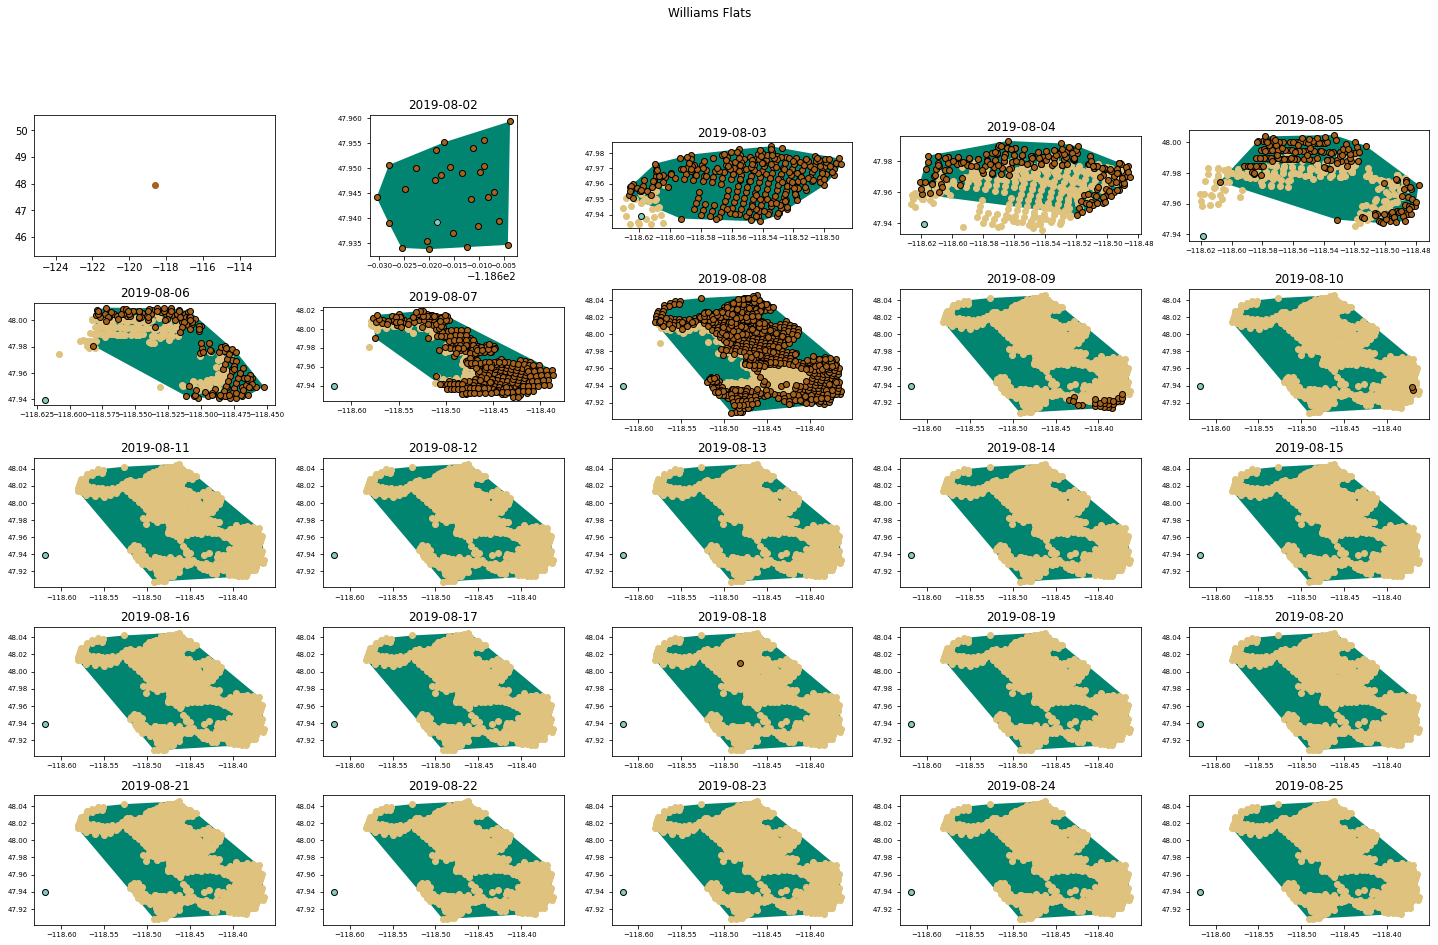

In [20]:
incidents = wf
print(incidents)
count = 0
for jj in range(len(incidents)): # loop through the incidents table
    print(jj)
    # generate the list of days that the fires cover
    days = np.arange(np.datetime64(incidents.iloc[jj]['First Day']), np.datetime64(incidents.iloc[jj]['Last Day'])+np.timedelta64(1,'D'), dtype='datetime64[D]')
    print(incidents.iloc[jj]['Fire Name'])
    inc_name = incidents.iloc[jj]['Fire Name']
    inc_num = incidents.iloc[jj]['Incident Number']
    #get location of the fire
    lat_fire = incidents.iloc[jj]['Lat Fire']
    lon_fire = incidents.iloc[jj]['Lon Fire']
    print(lon_fire, lat_fire)
    pt_start = Point(lon_fire, lat_fire)
    pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    poly_lats = np.array([lat_fire])
    
    #set up the plot
    nrows, ncols = choose_plot_grid_size(days)
    fig, axs = plt.subplots(nrows, ncols)
    fig.suptitle(incidents['Fire Name'].iloc[jj])
    fig.set_figheight(15)
    fig.set_figwidth(25)

    #plot the start location
    ax = axs[0,0]
    ax.scatter(lon_fire, lat_fire, c=colors[0])
    for ii in range(len(days)): # for each day
        #print(type(days[ii]))
        viirs_sub = viirs_all[(viirs_all['acq_date']==str(days[ii]))]
        lat = viirs_sub['latitude']
        lon = viirs_sub['longitude']
        poly, poly_lats, poly_lons = build_today_polygon(pt_start, lat, lon, lat_old, lon_old, 0.04, 0)
        num_viirs = len(poly_lats)
        print(num_viirs, 'VIIRS detections')
        if num_viirs==0: #if no points, persist the previous polygon
            #print('persisting previous polygon')
            poly = pt_start
            poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))]
        elif (num_viirs<=0.1*len(lat_old))|(num_viirs<=2): #if points drop off by >90% or to 2 or fewer
            #use old polygon, and ADD THE NEW POINTS, just in case
            lat_old = np.append(lat_old, poly_lats)
            lon_old = np.append(lon_old, poly_lons)
            poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))]
            poly = MultiPoint(poly_tups).convex_hull
        else: #make a new polygon 
            #print('HELLO!')
            old_poly_tups = [list((lon_old[i], lat_old[i])) for i in range(len(lat_old))] #old polygon points
            poly_tups = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lats))] #new polygon points
            poly_tups = [item for item in poly_tups if item not in old_poly_tups] #get rid of duplicates
            poly = MultiPoint(poly_tups).convex_hull
        
        poly_plot = gpd.GeoSeries(poly)
        #plot the polygon and viirs detects
        cnum = (ii+1)%ncols
        rnum = int(np.floor((ii+1)/nrows))
        ax = axs[rnum, cnum]
        poly_plot.plot(ax=ax, color = colors[3])
        ax.scatter(lon_old, lat_old, c=colors[1])#, edgecolor='k')
        ax.scatter(poly_lons, poly_lats, c = colors[0], edgecolor='k')
        ax.scatter(lon_fire, lat_fire, c=colors[2], edgecolor='k')
        ax.set_title(str(days[ii]))
        ax.xaxis.set_tick_params(labelsize=7)
        ax.yaxis.set_tick_params(labelsize=7)


        
        #fill in the geodataframe
        #fire_series.iloc[count]= [inc_num,inc_name, days[ii], lat_fire, lon_fire, len(poly_lats), poly]
        #print(fire_series)
        lat_old = [poly_tups[i][1] for i in range(len(poly_tups))]
        lon_old = [poly_tups[i][0] for i in range(len(poly_tups))]
        pt_start=poly
        count = count+1
        #print(count)


In [53]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon_viz_process(shape, lats, lons, lat_old, lon_old, bf, plot_evol):
    shape_buff = shape.buffer(bf)
    #find the points that are inside the buffer
    lat_new = np.nan*np.zeros(len(lats))
    lon_new = np.nan*np.zeros(len(lons))
    i = 0
    for pair in zip(lons, lats):
        pt_check = Point(pair)
        if shape_buff.contains(pt_check):
            #add the point to the list
            lat_new[i] = pair[1]
            lon_new[i] = pair[0]
            i = i+1            
    #grab the new points
    lat_new = lat_new[np.where(~np.isnan(lat_new))]
    lon_new = lon_new[np.where(~np.isnan(lon_new))]

    #make a shape around them
    tups = [list((lon_new[i], lat_new[i])) for i in range(len(lat_new))]
    mp = MultiPoint(tups).convex_hull

    if plot_evol == 1: #plot the new polygon
        print(len(lat_new), len(lon_new))
    
        #m = gpd.GeoSeries(mp)
        gdf_bdry = gpd.GeoDataFrame({'geometry': [shape_buff.boundary]})#, mp]})
        gdf_mp = gpd.GeoDataFrame({'geometry': [mp]})
        fig, ax = plt.subplots() 
        gdf_bdry['geometry'].plot(color=colors[1], ax=ax)
        gdf_mp['geometry'].plot(color=colors[3], ax=ax)
        plt.scatter(lon_new, lat_new, c = colors[0], edgecolor='k')
        plt.scatter(lon_old, lat_old, c = colors[1])#, edgecolor='k')
        plt.scatter(lon_fire, lat_fire, c= colors[2])
        plt.title('Halo, Polygon, and Points')
        plt.show()
    
    if (len(lat_new)-len(lat_old))>0: #if we are adding points
        #print('Time for recursive call')
        return build_today_polygon_viz_process(mp, lats, lons, lat_new, lon_new, bf, plot_evol)
    else:
        if plot_evol==1:
            gdf = gpd.GeoDataFrame({'geometry': [mp]})
            ax = plt.axes(projection=ccrs.PlateCarree())
            ax.coastlines()
            ax.set_extent([-120, -116, 47, 49])
            ax.add_feature(cartopy.feature.STATES, linestyle='-', alpha=.5)
            plt.scatter(-118.618333, 47.939167, marker ='*', c = 'r')
            gdf['geometry'].plot(color=colors[3], ax=ax)
            plt.scatter(lon_new, lat_new, c = colors[0], edgecolor='k')
            plt.scatter(lon_fire, lat_fire, c=colors[2])
            plt.title('Final Polygon and included points')
            plt.show()
        return mp, lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON

     Incident Number       Fire Name   First Day    Last Day   Lat Fire  \
175       10716356.0  Williams Flats  2019-08-02  2019-08-25  47.939167   

       Lon Fire  
175 -118.618333  
<class 'str'>
11 11


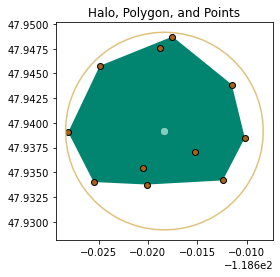

25 25


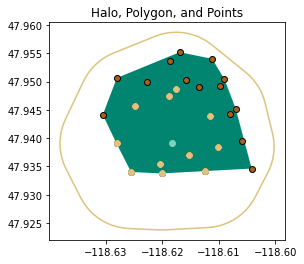

27 27


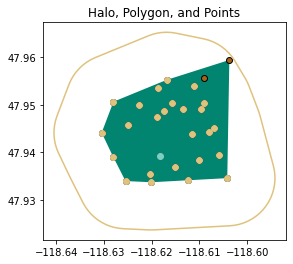

27 27


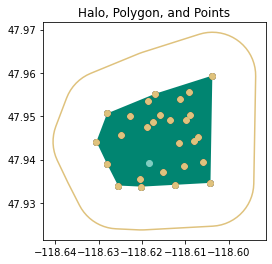

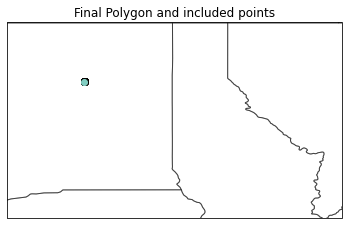

In [51]:
#plot the first day of WF
wf = incidents[incidents['Fire Name']=='Williams Flats']
print(wf)
wf_firstday = wf['First Day'].values
#make the starting point for the fire
lat_fire = wf['Lat Fire'].values
lon_fire = wf['Lon Fire'].values
pt_start = Point(lon_fire, lat_fire)
lat_old = np.array([lat_fire])
lon_old = np.array([lon_fire])

print(type(wf_firstday[0]))
viirs_sub = viirs_all[(viirs_all['acq_date']==str('2019-08-02'))]
lats = viirs_sub['latitude'].values
lons = viirs_sub['longitude'].values

poly, poly_lats, poly_lons= build_today_polygon_viz_process(pt_start, lats, lons, lat_old, lon_old, 0.01, 1)
